Description and information about the project goes here

In [2]:
# Imports
import pandas as pd
import numpy as np
import openpyxl
import xlsxwriter
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import string
import string
import spacy
from emotion import Emotion
import json
from wnaffect import WNAffect
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import heapq
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('dict')
nltk.download('wordnet')
nltk.download('wordnet_ic')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/protago/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/protago/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/protago/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/protago/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Error loading dict: Package 'dict' not found in index
[nltk_data] Downloading package wordnet to /home/protago/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet_ic to
[nltk_data]     /home/protago/nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/protago/

True

Task 1 save topic

Processes the dialogue data and creates an excel file for a specified dailydialogue topic, or all topics. Rows are dialogues, columns utterances

In [3]:
# Extracts all line numbers of lines in the specified topic. The topic_number argument must be given as a string. For example: '9'
# Topic number 9 is politics
def save_topic_lines(path_to_topic_file, topic_number):

    topic_lines = []
    topic_number = str(topic_number)

    with open(path_to_topic_file, 'r') as file:
        
        i = 1

        for line in file:
            if line[0] == topic_number:
                topic_lines.append(i)
            
            i = i + 1

    return topic_lines

# Extracts all dialogue lines from a specific topic
# if topic is 'all', every topic is extracted
def extract_topic(path_to_dialogue_file, path_to_topic_file, topic_number):

    topic_lines = save_topic_lines(path_to_topic_file, topic_number)
    topic_dialogue = []

    with open(path_to_dialogue_file, 'r', encoding='utf-8') as file:
        for line_number, line in enumerate(file):

            if topic_number == 'all':
                topic_dialogue.append(line)

            elif topic_number != 'all':
                if line_number in topic_lines:
                    topic_dialogue.append(line)

    return topic_dialogue

# Creates a pandas dataframe for the dialogue data in a specific topic
# Rows are dialogue lines. They are in the same order as in the original dialogues_text.txt file
# Columns are utterances in that dialogue.
def create_topic_dataframe(path_to_dialogue_file, path_to_topic_file, topic_number):

    topic_dialogue = extract_topic(path_to_dialogue_file, path_to_topic_file, topic_number)


    #split_dialogue = [line.split('__eou__') for line in topic_dialogue]

    split_dialogue = []

    for line in topic_dialogue:

        split_line = line.split('__eou__')

        for i in range(len(split_line)):
            
            if split_line[i][0] == " ":

                new_line = split_line[i][1:]
                split_line[i] = new_line

            if split_line[i][-1] == " ":

                new_line = split_line[i][:-1]
                split_line[i] = new_line


        split_dialogue.append(split_line)


    topic_dialogue_data = pd.DataFrame(split_dialogue)

    return topic_dialogue_data

# Saves the dataframe in excel format
# This is just for not having to write the annoying file format
def save_dataframe_as_excel(data, filename):

    if '.xlsx' not in filename:
        filename = filename + '.xlsx'

    data.to_excel(filename, header=False, index=False)

# Does everything above. Extracts the topic, makes it into a dataframe and saves in excel format
# if topic number is 'all', every topic is extracted
def extract_and_save_topic_dialogue(path_to_dialogue_file, path_to_topic_file, topic_number, filename):

    topic_dialogue_data = create_topic_dataframe(path_to_dialogue_file, path_to_topic_file, topic_number)
    save_dataframe_as_excel(topic_dialogue_data, filename)

# Give topic number and name of file to save the data. The topic number can be given as a string or an integer.
extract_and_save_topic_dialogue('ijcnlp_dailydialog/dialogues_text.txt', 'ijcnlp_dailydialog/dialogues_topic.txt', 'all', 'all_dialogue_data')

Task 1 statistics

Takes the excel format data from task 1 save topic as input and calculates the vocabulary size, total number of utterances and average number of tokens, pronouns and agreement/negation wording per utterances for those dialogues.

In [3]:
# Open the data that was made with task1_save_topic.py
def open_process_data(name_of_excel_file):
    
    data = pd.read_excel(name_of_excel_file)
    rows, columns = data.shape
    dialogues = []
    
    for row in range(rows):

        utterances = []

        for column in range(columns):
            if type(data.iat[row, column]) is str:
                utterances.append(data.iat[row, column])
            
        dialogues.append(utterances)

    return dialogues

# Tokenizes, lowers and removes special characters from data
def tokenize_data(dialogues):
    
    special = ['!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '-', '=', '+', '[', ']', '{', '}', ';', ':', '"', "'", '<', '>', ',', '.', '/', '?', '\\', '|', '`', '~', '...']
    tokenized_dialogues = []

    for dialogue in dialogues:
        tokenized_dialogue = []

        for utterance in dialogue:
            processed_tokenized_utterance = []
            tokenized_utterance = word_tokenize(utterance)

            for token in tokenized_utterance:
                token.lower()
                if (token not in special) and (len(token) != 1):
                    processed_tokenized_utterance.append(token)
                
            tokenized_dialogue.append(processed_tokenized_utterance)
        
        tokenized_dialogues.append(tokenized_dialogue)
    
    return tokenized_dialogues

# Calculates the vocabulary size for data. Data is given in the form that tokenize_data returns it
def vocabulary_size(dialogues):
    
    tokenized_dialogues = tokenize_data(dialogues)
    counted_words = []
    vocabulary_size = 0

    for dialogue in tokenized_dialogues:
        for utterance in dialogue:
            for token in utterance:
                if token not in counted_words:
                    vocabulary_size += 1
                    counted_words.append(token)
                    #print("Unique token: " + token)

    return vocabulary_size

# Calculates the number of utterances for a dialogue
def count_utterances(dialogues):

    num_of_utterances = 0

    for dialogue in dialogues:
        for utterance in dialogue:
            num_of_utterances += 1

    return num_of_utterances

# Count average tokens per utterance for dialogue
def count_avg_tokens_per_utterance(dialogues):

    num_of_utterances = count_utterances(dialogues)
    tokenized_dialogues = tokenize_data(dialogues)
    total_tokens = 0

    for dialogue in tokenized_dialogues:
        for utterance in dialogue:
            total_tokens += len(utterance)

    avg_tokens_per_utterance = total_tokens / num_of_utterances

    return avg_tokens_per_utterance


# Uses NLTK part of speech tagger to identify pronouns, counts
# the number of pronouns and then the average per utterance
def avg_pronouns_per_utterance(dialogues):
    
    tokenized_dialogues = tokenize_data(dialogues)
    pronoun_count = 0

    for dialogue in tokenized_dialogues:
        for utterance in dialogue:
            tagged_utterance = pos_tag(utterance)

            for (token, prp_tag) in tagged_utterance:
                if prp_tag == ('PRP' or 'PRP$'):
                    pronoun_count += 1

    num_of_utterances = count_utterances(dialogues)
    avg_prp = pronoun_count / num_of_utterances

    return avg_prp


# Didn't find any clear resource for agreement or negation wording.
# There is nltk.metrics.agreement, but it is not for counting agreement words
# There is also the option to try and find negation/agreement related words through wordnet, but it would also find words that are not specifially negation/agreement words
# The custom list of agreement/negation words is subject to change
# choice = 1 counts average number of agreement words
# choice = 2 does the same for negation words
def avg_agreement_negation_per_utterance(dialogues, choice):

    agreement_words = ['yes', 'ok', 'sure', 'okay', 'agreed', 'agree']
    negation_words = ['no', 'not', "don't", "can't", 'neither', ]

    if choice == 1:
        words_to_count = agreement_words
    elif choice == 2:
        words_to_count = negation_words
    else:
        print("Second argument: 1 for agreement words, 2 for negation words")
        return 0

    tokenized_dialogues = tokenize_data(dialogues)
    num_of_utterances = count_utterances(dialogues)
    num_words_to_count = 0

    for dialogue in tokenized_dialogues:
        for utterance in dialogue:
            for token in utterance:
                if token in words_to_count:
                    num_words_to_count = num_words_to_count + 1
    
    avg_agreement_negation = num_words_to_count / num_of_utterances

    return avg_agreement_negation

# Prints all stats for a given topic
def print_stats_from_excel(name_of_excel_file):

    if '.xlsx' not in name_of_excel_file:
        name_of_excel_file = name_of_excel_file + '.xlsx'

    dialogues = open_process_data(name_of_excel_file)
    vocab = vocabulary_size(dialogues)
    utterances = count_utterances(dialogues)
    tokens_per_utterance = count_avg_tokens_per_utterance(dialogues)
    avg_prp = avg_pronouns_per_utterance(dialogues)
    avg_agreement = avg_agreement_negation_per_utterance(dialogues, 1)
    avg_negation = avg_agreement_negation_per_utterance(dialogues, 2)

    print("Stats for file \"" + name_of_excel_file + "\":")
    print("Size of vocabulary: " + str(vocab))
    print("Number of utterances: " + str(utterances))
    print("Average number of tokens per utterance: " + str(tokens_per_utterance))
    print("Average number of pronouns per utterance: " + str(avg_prp))
    print("Average number of agreement words per utterance: " + str(avg_agreement))
    print("Average number of negation words per utterance: " + str(avg_negation))


# Give name of the excel data file, where the dialogue data saved with previous block is stored
print_stats_from_excel('all_dialogue_data')

Stats for file "all_dialogue_data.xlsx":
Size of vocabulary: 26273
Number of utterances: 116095
Average number of tokens per utterance: 9.505758215254748
Average number of pronouns per utterance: 0.9111158964641026
Average number of agreement words per utterance: 0.024342133597484817
Average number of negation words per utterance: 0.0490288126103622


Task 2

Calculates the average number of person/organization named-entities per utterance, for dialogue data in the task 1 save topic excel format.

In [4]:
# Opens an excel data file saved in the format that task1_save_topic.py saves and
# calculates the entity tags per utterance
def avg_person_organization_entity_tags_per_utterance(excel_file_name):

    if '.xlsx' not in excel_file_name:
        excel_file_name = excel_file_name + '.xlsx'

    entity_tagger = spacy.load("en_core_web_md")
    dialogues = open_process_data(excel_file_name)
    num_entities = 0

    for dialogue in dialogues:
        for utterance in dialogue:
            entity_tagged_utterance = entity_tagger(utterance)

            for entity in entity_tagged_utterance.ents:
                if entity.label_ == ("ORG" or "PERSON"):
                    num_entities += 1

    num_utterances = count_utterances(dialogues)
    avg_ent_tag_per_utterance = num_entities / num_utterances

    return avg_ent_tag_per_utterance

# Give name of the excel data file, where the dialogue data is saved
ent_tags_avg = avg_person_organization_entity_tags_per_utterance('all_dialogue_data')
print("Average number of person/organization named-entities per utterance: " + str(ent_tags_avg))

Average number of person/organization named-entities per utterance: 0.027253542357552004


Task 3 Emotion analysis using WNAffect

Gives result for approaches A1 and A2 discussed in the report.

In order to run this task, wordnet-1.6 and wn-domains-3.2 are required.

In [5]:
# Loads and parses dialogues from a text file dialogues_text.txt
# separating each utterance by __eou__ and returns a list of lists (one per dialogue).
def get_dialogs():

    with open("ijcnlp_dailydialog/dialogues_text.txt", "r", encoding="utf-8") as file:
        dialogs = file.readlines()

    parsed_dialogs = []
    for dialog in dialogs:
        d = dialog.split("__eou__")
        d = d[:-1]
        parsed_dialogs.append(d)

    return parsed_dialogs

# Tokenizes each utterance and tags each word’s part of speech (POS).
# Queries WNAffect to get emotions for each word in the utterance based on POS tags, accumulating any detected emotions in a list.
# Returns list of emotions for utterance
def get_emotions(utterance):

    tokens = word_tokenize(utterance)
    pos_tags = pos_tag(tokens)

    emotions = []
    for i in range(len(tokens)):
        emo = wna.get_emotion(tokens[i], pos_tags[i][1])
        if emo != None:
            emotions.append(emo.name)
            Emotion.printTree(Emotion.emotions[emo.name])
            parent = emo.get_level(emo.level - 1)
            print("parent: " + parent.name)

    return emotions

# Calculates Accuracy, precision and recall scores for predicted WNAffect emotions.
def validate_m(emotions):
    
    emotion_tags = get_emotions(get_dialogs())

    emo_tags = {0: "no emotion", 1: "anger", 2: "disgust", 3: "fear", 4: "happiness", 5: "sadness", 6: "surprise"}

    y_true = []
    for tag in emotion_tags:
        y_true.append(emo_tags[int(tag)])

    y_pred = get_pred_class(emotions, y_true)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro', zero_division=np.nan)

    print("Accuracy: " + str(round(accuracy ,3)))
    print("Precision: " + str(round(precision, 3)))
    print("Recall: " + str(round(recall, 3)))

# Preprocessing and prediction of the class of the emotion from WNAffect
def get_pred_class(emotions, y_true):

    y_pred = []
    for i in range(len(emotions)):
        if y_true[i] in emotions[i]:
            y_pred.append(y_true[i])
        elif len(emotions[i]) == 0:
            y_pred.append('no emotion')
        elif 'negative-fear' in emotions[i] or 'ambiguous-fear' in emotions[i]:
            if y_true[i] == 'fear':
                y_pred.append('fear')
            else:
                y_pred.append(emotions[i][0])
        else:
            y_pred.append(emotions[i][0])
    
    return y_pred

# Calls get_dialogs to load dialogues.
# Saves emotions fro each utterance to emos.json
def save_emotions():
    dialogs = get_dialogs()

    emotions = []
    for dialog in dialogs:
        dialog_emo = []
        for utterance in dialog:
            emo = get_emotions(utterance)
            dialog_emo.append(emo)
        emotions.append(dialog_emo)

    with open("emos.json", "w") as f:
        json.dump(emotions, f, indent=4)

def results_a1():
    with open("emos.json", "r") as f:
        data = json.load(f)
    emos = []
    for d in data:
        for u in d:
            emos.append(u)

    validate_m(emos)

def results_a2():
    with open("emos_upperlevel.json", "r") as f:
        data = json.load(f)
    emos = []
    for d in data:
        for u in d:
            emos.append(u)

    validate_m(emos)

wna = WNAffect('wordnet-1.6/', 'wn-domains-3.2/')

# Results for approaches A1 and A2 (reference to report)
results_a1()
results_a2()

TypeError: expected string or bytes-like object, got 'list'

Task 4 Sentiment analysis with Vader sentiment analyser

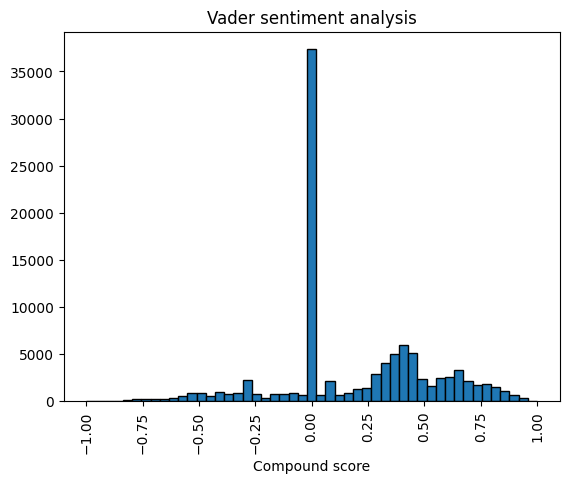

In [6]:
# Saves Vader sentiment analyser results to sentiments.json
def save_sentiment():
    
    analyzer = SentimentIntensityAnalyzer()
    dialogs = get_dialogs()

    dialog_sentiments = []
    for dialog in dialogs:
        utterances = []
        for utterance in dialog:
            vs = analyzer.polarity_scores(utterance)
            utterances.append(vs)
            print("{:-<65} {}".format(utterance, str(vs)))
        dialog_sentiments.append(utterances)

    with open("sentiments.json", "w", encoding="utf-8") as file:
        json.dump(dialog_sentiments, file, indent=4)

# Reads sentiments.json and shows compound distribution of the results
def results():

    with open("sentiments.json", 'r') as file:
        sentiments = json.load(file)
    
    compounds = []
    for dialog in sentiments:
        for sentiment in dialog:
            compounds.append(sentiment['compound'])

    bins = np.linspace(-1,1)
    data = compounds
    plt.hist(data, bins=bins, edgecolor='black')
    plt.xticks(rotation=90)
    plt.title('Vader sentiment analysis')
    plt.xlabel('Compound score')

    plt.show()

results()

Task 5 Correlation study between the sentiment and emotion states

Prints values and shows both with none value results and without none values.

In order to running this task, wordnet-1.6 and wn-domains-3.2 is required.

incompatible:  85042
partial compability:  2501
Full compability:  15437


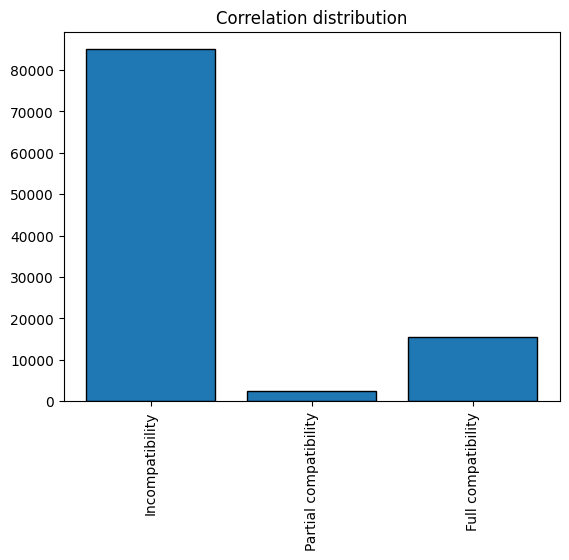

incompatible:  8450
partial compability:  2501
Full compability:  15437


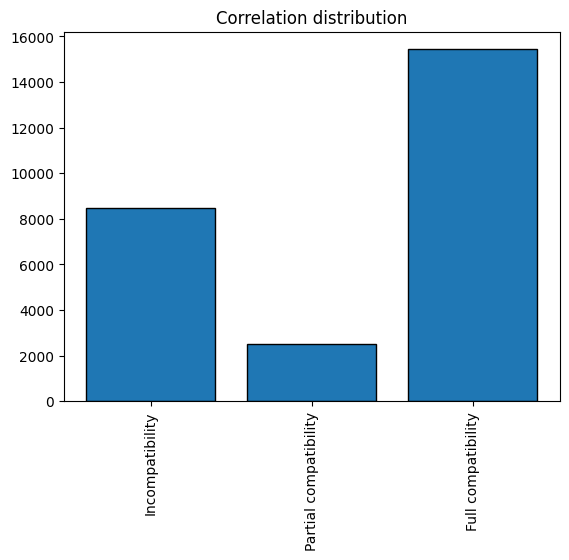

In [7]:

wna = WNAffect('wordnet-1.6/', 'wn-domains-3.2/')

# Saves level 4 emotions (ambiguous, neutral, negative and positive) to the emos_upper_level.json file
def save_upper_level_emotions():
    dialogs = get_dialogs()

    emotions = []
    for dialog in dialogs:
        dialog_emo = []
        for utterance in dialog:
            emo = get_emotions(utterance)
            dialog_emo.append(emo)
        emotions.append(dialog_emo)

    with open("emos_upper_level.json", "w") as f:
        json.dump(emotions, f, indent=4)

# Tokenizes each utterance and tags each word’s part of speech (POS).
# Gets level 4 emotions for all emotions found with WNAffect
def get_emotions(utterance):

    tokens = word_tokenize(utterance)
    pos_tags = pos_tag(tokens)

    emotion_tags = []
    for i in range(len(tokens)):
        emo = wna.get_emotion(tokens[i], pos_tags[i][1])
        if emo != None:
            emotion = get_upper_level_emotion(emo)
            emotion_tags.append(emotion)
            # Emotion.printTree(Emotion.emotions[emo.name])
            # parent = emo.get_level(emo.level - 1)
            # print("parent: " + parent.name)

    return emotion_tags

# Helper function for searching the WNAffect emotion tree to level 4
def get_upper_level_emotion(emo):

    parent = emo.get_level(emo.level - 1)
    if emo.name == 'love':
        for child in emo.children:
            print(child.name)

    while parent.name != "negative-emotion" and parent.name != "positive-emotion" and parent.name != "positive-emotion" and parent.name != "ambiguous-emotion" and parent.name != "neutral-emotion":
        parent = emo.get_level(parent.level - 1)
    
    if parent.name == "ambiguous-emotion" or parent.name == "neutral-emotion":
        return 0
    elif parent.name == "negative-emotion":
        return -1
    else:
        return 1

# Compares level 4 emotions to Vader sentiments.
def compare_and_save():

    with open("emos_upper_level.json", "r") as file:
        upper_level = json.load(file)
    
    with open("sentiments.json", "r") as file:
        sentiments = json.load(file)

    compared_index = []
    for i in range(len(upper_level)):
        dialogs = []
        for j in range(len(upper_level[i])):
            result = get_compared_result(sentiments[i][j]["compound"], upper_level[i][j])
            dialogs.append(result)
        compared_index.append(dialogs)

    save_to_excel(compared_index, upper_level, sentiments, get_dialogs())

# Saves compatibility index, emotion value, sentiment, and corresponding utterance to the excel file task5_data.xlsx 
def save_to_excel(compared_index, emotion_values, sentiments, dialogs):
    data = {}
    compability_index_list = []
    emotion_values_list = []
    sentiments_list = []
    utterances_list = []
    for i in range(len(compared_index)):
        compability_index_list.extend(compared_index[i])
        for j in range(len(compared_index[i])):
            if len(emotion_values[i][j]) == 0:
                emotion_values_list.append("None")
            else:
                emotion_values_list.append(emotion_values[i][j])
            sentiments_list.append(sentiments[i][j]["compound"])
            utterances_list.append(dialogs[i][j])
    data["compability index"] = compability_index_list
    data["emotion value"] = emotion_values_list
    data["sentiment"] = sentiments_list
    data["utterance"] = utterances_list

    df = pd.DataFrame(data)
    df.to_excel("task5_data.xlsx", index=False)

# Helper function for crating conpatibility index
def get_compared_result(sentiment_value, emotion_values):
    if sentiment_value >= 0.05:
        if 1 in emotion_values:
            if 0 not in emotion_values and -1 not in emotion_values:
                return 1
            return 0.5
        else:
            return 0
    elif sentiment_value <= -0.05:
        if -1 in emotion_values:
            if 1 not in emotion_values and 0 not in emotion_values:
                return 1
            return 0.5
        else:
            return 0
    else:
        if 0 in emotion_values:
            if 1 not in emotion_values and -1 not in emotion_values:
                return 1
            return 0.5
        else:
            return 0

# Results with none values
def results():
    df = pd.read_excel('task5_data.xlsx')
    correlation = df['compability index']

    counts = correlation.value_counts().sort_index()

    print('incompatible: ', counts[0])
    print('partial compability: ', counts[0.5])
    print('Full compability: ', counts[1])

    bin_labels = ['Incompatibility', 'Partial compatibility', 'Full compatibility']

    plt.bar(bin_labels, counts, edgecolor='black')
    plt.xticks(rotation=90)
    plt.title('Correlation distribution')

    plt.show()

# Results with no none values
def results_none_removed():
    df = pd.read_excel('task5_data.xlsx')
    correlation = df['compability index']
    emo_value = df['emotion value']

    no_none_correlation = []
    for i in range(len(correlation)):
        if not pd.isna(emo_value[i]):
            no_none_correlation.append(correlation[i])
    
    nncor = {}
    nncor['compability index'] = no_none_correlation
    df = pd.DataFrame(nncor)

    counts = df['compability index'].value_counts().sort_index()

    print('incompatible: ', counts[0])
    print('partial compability: ', counts[0.5])
    print('Full compability: ', counts[1])

    bin_labels = ['Incompatibility', 'Partial compatibility', 'Full compatibility']

    plt.bar(bin_labels, counts, edgecolor='black')
    plt.xticks(rotation=90)
    plt.title('Correlation distribution')

    plt.show()

results()
results_none_removed()

Task 6

Uses NLTK naïve Bayes classifier trained with the NLTK nps chat data, to predict dialogue acts for each utterance in dialogue data that is in the task 1 save topic excel format. Saves all the predictions into json format, where the inner list elements are dialogues and outer list elements are predictions for the utterances.

In [8]:
# Opens excel data and saves it into a multidimensional list
# Use task1_save_topic.py to save topic dialogues in this excel form
def open_process_data(name_of_data_file):
    
    data = pd.read_excel(name_of_data_file, header=None)
    rows, columns = data.shape
    dialogs = []

    for row in range(rows):
        utterances = []

        for column in range(columns):
            if (type(data.iat[row, column]) is str) & (data.iat[row, column] != "\n"):
                utterances.append(data.iat[row, column])
            
        dialogs.append(utterances)

    return dialogs

# Feature extraction function as specified in the NLTK organization book chapter 6, section 2.2
def dialogue_act_features(post):
    features = {}
    for word in nltk.word_tokenize(post):
        features['contains({})'.format(word.lower())] = True
    return features

# Trains the classifier as specified in the NLTK organization book chapter 6, section 2.2
def train_NLTK_model():

    nltk.download('nps_chat')
    posts = nltk.corpus.nps_chat.xml_posts()[:10000]

    featuresets = [(dialogue_act_features(post.text), post.get('class')) for post in posts]
    size = int(len(featuresets) * 0.1)
    train_set, test_set = featuresets[size:], featuresets[:size]
    classifier = nltk.NaiveBayesClassifier.train(train_set)
    print("Classifier accuracy on the NLTK NPS corpus: " + str(nltk.classify.accuracy(classifier, test_set)))

    return classifier

# Classifies data from an excel file
def classify_data(name_of_data_file):

    if '.xlsx' not in name_of_data_file:
        name_of_data_file = name_of_data_file + '.xlsx'

    data = open_process_data(name_of_data_file)
    classifier = train_NLTK_model()

    predictions = []

    for dialog in data:
        dialog_predictions = []

        for utterance in dialog:
            utterance_features = dialogue_act_features(utterance)
            prediction = classifier.classify(utterance_features)
            dialog_predictions.append(prediction)

        predictions.append(dialog_predictions)

    return predictions
    
# Saves predictions
def save_to_json(predictions, saved_file_name):

    if '.json' not in saved_file_name:
        saved_file_name = saved_file_name + '.json'    

    with open(saved_file_name, "w") as file:
        json.dump(predictions, file, indent=4)

# Give name of the excel data file, where the dialogue data is saved
predictions = classify_data('all_dialogue_data')
save_to_json(predictions, 'all_dialogue_predictions')

[nltk_data] Downloading package nps_chat to /home/protago/nltk_data...
[nltk_data]   Package nps_chat is already up-to-date!


Classifier accuracy on the NLTK NPS corpus: 0.667


Task 7

This task does not meet the project details. I first started working on it in the wrong angle. Then I started calculating the pearson correlations, but ended up not calculating the correct correlations. The code creates 3 pandas dataframes, where each have dialogues as rows and utterances as columns. First dataframe has the utterances dialogue acts, another has the utterances compound sentiments and last one has the utterances emotions. Then the code removes empty columns and calculates the column wise pearson correlation.

Requires emotion data from task 3, sentiment data from task 4 and dialogue act data from task 6. For all dialogue acts, counts the occurences of all different emotions and returns the emotion that appears the most with that dialogue act. Calculates the average compound sentiment for all dialogue acts by summing them together and dividing by the number of compound sentiments added.

In [ ]:
# Calculates the emotion most associated with each dialogue act and the average compound sentiment of each dialogue act
def calculate_matching(dialogue_acts_data_file, emotions_file, sentiments_file):

    with open(dialogue_acts_data_file, 'r', encoding='utf-8') as file:
        dialogue_acts_data = json.load(file)

    with open(emotions_file, 'r', encoding='utf-8') as file:
        emotions = json.load(file)

    with open(sentiments_file, 'r', encoding='utf-8') as file:
        sentiments = json.load(file)

    # The first element in the list holds a dictionary that has emotions as keys and the number of times that
    # emotion has appeared in the same utterance for that dialogue act as values
    # The second element in the list holds the compound sentiment and third keeps track of how many compound
    # sentiments were added together
    correlations = {
        "Emotion": [{}, 0, 0],
        "yAnswer": [{}, 0, 0],
        #"yAnswer" : [{}, 0, 0],
        "Continuer": [{}, 0, 0],
        "whQuestion": [{}, 0, 0],
        "System": [{}, 0, 0],
        "Accept": [{}, 0, 0],
        "Clarify": [{}, 0, 0],
        #"Clarity": [{}, 0, 0],
        "Emphasis": [{}, 0, 0],
        "nAnswer": [{}, 0, 0], 
        "Greet": [{}, 0, 0],
        "Statement": [{}, 0, 0],
        "Reject": [{}, 0, 0],
        "Bye": [{}, 0, 0],
        "Other" : [{}, 0, 0],
        #"Others" : [{}, 0, 0],
        "ynQuestion" : [{}, 0, 0],
    }

    # Iterate over each utterance in each dialogue
    for dialogue in range(len(dialogue_acts_data)):
        for utterance in range(len(dialogue_acts_data[dialogue])):

            
            dialogue_act = dialogue_acts_data[dialogue][utterance]
            sentiment = sentiments[dialogue][utterance]

            # If emotions list is empty, then emotions[dialogue][utterance][0] doens't exist,
            # but if it has an emotion, then emotions[dialogue][utterance] is a list and not a string
            if len(emotions[dialogue][utterance]) != 0:
                emotion = emotions[dialogue][utterance][0]
            else:
                emotion = 'NaN'

            # Adds emotion or increments emotion value in the correlations dict lists first dictionary
            # If emotion is not found before for this dialogue act, it is added to the dict as a key, with a value of one.
            # Otherwise the value for that key is incremented by one
            # If emotion is nan, do nothing
            if emotion == 'NaN':
                a = 1
            elif emotion in correlations[dialogue_act][0]:
                correlations[dialogue_act][0][emotion] += 1
            else:
                correlations[dialogue_act][0][emotion] = 1

            # Adds compound sentiment to the correlations dict lists second element
            correlations[dialogue_act][1] += sentiment["compound"]
            correlations[dialogue_act][2] += 1

    # This list stores lists, which have two elements. First is a dialogue act, second is the emotion that dialogue act has
    # the highest correlation with, i.e. they appear the most together
    highest_emotion_correlations = []

    for dialogue_act in correlations:
        
        # Get average compound sentiment
        correlations[dialogue_act][1] = correlations[dialogue_act][1] / correlations[dialogue_act][2]
        print("Compound sentiment for " + str(dialogue_act) + " is: " + str(correlations[dialogue_act][1]))

        # For each dialogue act, find emotion that appears the most with it
        if len(correlations[dialogue_act][0]) != 0:
            highest_emotion_correlations.append([dialogue_act, max(correlations[dialogue_act][0], key=correlations[dialogue_act][0].get)])

    return correlations, highest_emotion_correlations

# The data in dialogue act dataframe is converted to be numerical in this format
# none = 0
#"Emotion" = 1
#"yAnswer" = 2
#"Continuer" = 3
#"whQuestion" = 4
#"System" = 5
#"Accept" = 6
#"Clarify" = 7
#"Emphasis" = 8
#"nAnswer" = 9
#"Greet" = 10
#"Statement" = 11
#"Reject" = 12
#"Bye" = 13
#"Other" = 14
#"ynQuestion" = 15
def calculate_correlations(dialogue_acts_data_file, emotions_file, sentiments_file):

    # Load data into dataframes
    dialogue_acts_dataframe = pd.read_json(dialogue_acts_data_file)
    emotions_dataframe = pd.read_json(emotions_file)
    sentiments_dataframe= pd.read_json(sentiments_file)

    # Change dialogue acts into numerical variables
    # Let none be 0
    dialogue_rows, dialogue_columns = dialogue_acts_dataframe.shape
    for row in range(dialogue_rows):
        for column in range(dialogue_columns):
            if dialogue_acts_dataframe.iloc[row, column] == 'Emotion':
                dialogue_acts_dataframe.iloc[row, column] = 1
            elif dialogue_acts_dataframe.iloc[row, column] == 'yAnswer':
                dialogue_acts_dataframe.iloc[row, column] = 2
            elif dialogue_acts_dataframe.iloc[row, column] == 'Continuer':
                dialogue_acts_dataframe.iloc[row, column] = 3
            elif dialogue_acts_dataframe.iloc[row, column] == 'whQuestion':
                dialogue_acts_dataframe.iloc[row, column] = 4
            elif dialogue_acts_dataframe.iloc[row, column] == 'System':
                dialogue_acts_dataframe.iloc[row, column] = 5
            elif dialogue_acts_dataframe.iloc[row, column] == 'Accept':
                dialogue_acts_dataframe.iloc[row, column] = 6
            elif dialogue_acts_dataframe.iloc[row, column] == 'Clarify':
                dialogue_acts_dataframe.iloc[row, column] = 7
            elif dialogue_acts_dataframe.iloc[row, column] == 'Emphasis':
                dialogue_acts_dataframe.iloc[row, column] = 8
            elif dialogue_acts_dataframe.iloc[row, column] == 'nAnswer':
                dialogue_acts_dataframe.iloc[row, column] = 9
            elif dialogue_acts_dataframe.iloc[row, column] == 'Greet':
                dialogue_acts_dataframe.iloc[row, column] = 10
            elif dialogue_acts_dataframe.iloc[row, column] == 'Statement':
                dialogue_acts_dataframe.iloc[row, column] = 11
            elif dialogue_acts_dataframe.iloc[row, column] == 'Reject':
                dialogue_acts_dataframe.iloc[row, column] = 12
            elif dialogue_acts_dataframe.iloc[row, column] == 'Bye':
                dialogue_acts_dataframe.iloc[row, column] = 13
            elif dialogue_acts_dataframe.iloc[row, column] == 'Other':
                dialogue_acts_dataframe.iloc[row, column] = 14
            elif dialogue_acts_dataframe.iloc[row, column] == 'ynQuestion':
                dialogue_acts_dataframe.iloc[row, column] = 15
            else:
                dialogue_acts_dataframe.iloc[row, column] = 0
    
    # Let us only consider the compound sentiment of each utterance
    sentiment_rows, sentiment_columns = sentiments_dataframe.shape
    for row in range(sentiment_rows):
        for column in range(sentiment_columns):
            if isinstance(sentiments_dataframe.iloc[row, column], dict):
                sentiments_dataframe.iloc[row, column] = sentiments_dataframe.iloc[row, column]['compound']
            else:
                sentiments_dataframe.iloc[row, column] = 0
    
    # Impute the mean to the missing values NOT DONE YET!!!
    emotion_rows, emotion_columns = emotions_dataframe.shape
    for row in range(emotion_rows):
        for column in range(emotion_columns):
            if emotions_dataframe.iloc[row, column] == None:
                emotions_dataframe.iloc[row, column] = -1
            elif len(emotions_dataframe.iloc[row, column]) == 0:
                emotions_dataframe.iloc[row, column] = -1
            else:
                emotions_dataframe.iloc[row, column] = emotions_dataframe.iloc[row, column][0]

    # Remove constant columns
    # Find constant columns from the dialogue act dataframe
    const_columns = []
    for column in range(dialogue_columns):
        if dialogue_acts_dataframe.iloc[:, column].std() == 0:
            const_columns.append(column)

    # Remove the constant columns from all dataframes
    # Make two copies of the dialogue acts dataframe.
    # From one, the sentiment constant columns will be removed
    # and the emotion constant columns from the other
    dialogue_acts_sentiment_dataframe = dialogue_acts_dataframe.drop(dialogue_acts_dataframe.columns[const_columns], axis=1)
    dialogue_acts_emotion_dataframe = dialogue_acts_dataframe.drop(dialogue_acts_dataframe.columns[const_columns], axis=1)
    sentiments_dataframe = sentiments_dataframe.drop(sentiments_dataframe.columns[const_columns], axis=1)
    emotions_dataframe = emotions_dataframe.drop(emotions_dataframe.columns[const_columns], axis=1)

    # Reset const_columns and set the rows and columns values to the new dimensions, after removing columns
    const_columns = []
    sentiment_rows, sentiment_columns = sentiments_dataframe.shape

    # Find constant columns from the sentiments dataframe
    for column in range(sentiment_columns):
        if sentiments_dataframe.iloc[:, column].std() == 0:
            const_columns.append(column)

    # Remove the sentiment constant columns from sentiment & dialogue acts dataframes
    dialogue_acts_sentiment_dataframe = dialogue_acts_sentiment_dataframe.drop(dialogue_acts_sentiment_dataframe.columns[const_columns], axis=1)
    sentiments_dataframe = sentiments_dataframe.drop(sentiments_dataframe.columns[const_columns], axis=1)

    # Reset const_columns and set the rows and columns values to the new dimensions, after removing columns
    const_columns = []
    emotion_rows, emotion_columns = emotions_dataframe.shape

    # Find constant columns from the emotions dataframe
    for column in range(emotion_columns):
        if emotions_dataframe.iloc[:, column].std() == 0:
            const_columns.append(column)

    # Remove the emotion constant columns from emotion & dialogue acts dataframes
    dialogue_acts_emotion_dataframe = dialogue_acts_emotion_dataframe.drop(dialogue_acts_emotion_dataframe.columns[const_columns], axis=1)
    emotions_dataframe = emotions_dataframe.drop(emotions_dataframe.columns[const_columns], axis=1)

    # Calculate the correlations
    sentiment_correlation = dialogue_acts_sentiment_dataframe.corrwith(sentiments_dataframe)
    emotion_correlation = dialogue_acts_emotion_dataframe.corrwith(emotions_dataframe)

    return emotion_correlation, sentiment_correlation


# Prints the matches
correlations, highest_emotion_correlations = calculate_matching('all_dialogue_predictions.json', 'emos.json', 'sentiments.json')
print("List of lists with the dialogue acts as the first element and the emotion most associated with that dialogue act as the second element")
print(highest_emotion_correlations)

# Prints the correlations
emotion_correlation, sentiment_correlation = calculate_correlations('all_dialogue_predictions.json', 'emos_upper_level.json', 'sentiments.json')
print("Dialogue act / emotion correlations")
print(emotion_correlation)
print("Dialogue act / sentiment correlations")
print(sentiment_correlation)

Compound sentiment for Emotion is: -0.19733333333333333
Compound sentiment for yAnswer is: 0.4125599510318254
Compound sentiment for Continuer is: 0.14945422885572143
Compound sentiment for whQuestion is: 0.10348610379266035
Compound sentiment for System is: 0.06702743764172334
Compound sentiment for Accept is: 0.36048351449275456
Compound sentiment for Clarify is: 0.24550313324404716
Compound sentiment for Emphasis is: 0.281300698757766
Compound sentiment for nAnswer is: 0.0759587800369691
Compound sentiment for Greet is: 0.019240740740740742
Compound sentiment for Statement is: 0.19866943847343674
Compound sentiment for Reject is: 0.12184455385363421
Compound sentiment for Bye is: 0.17189492385786803
Compound sentiment for Other is: 0.2135223988439305
Compound sentiment for ynQuestion is: 0.1458641363683198
List of lists with the dialogue acts as the first element and the emotion most associated with that dialogue act as the second element
[['yAnswer', 'stupefaction'], ['Continuer', 

Task 8 Machine learning model for emotion predictions

If the kernel crashes when running this cell, use the task8.py file. When you have the dependencies, just run "python task8.py"

Prints statistics and shows confusion matrices for all four machine learning models used in the study

In [10]:
def get_sentiment(utterance):

    analyzer = SentimentIntensityAnalyzer()

    vs = analyzer.polarity_scores(utterance)
    if vs['compound'] <= -0.05:
        return 0
    elif vs['compound'] >= 0.05:
        return 2
    else:
        return 1

def get_pronouns(utterance):

    tokens = word_tokenize(utterance)
    pos_tags = pos_tag(tokens)

    counter = 0
    for pt in pos_tags:
        if pt[1] == 'PRP' or pt[1] == 'PRP$':
            counter += 1

    return counter

def get_negation(utterance):

    negation_terms = ['no', 'not', 'never', 'none', 'nobody', "don't", "can't", 'neither']

    tokens = word_tokenize(utterance)

    counter = 0
    for token in tokens:
        if token in negation_terms:
            counter += 1

    return counter

def get_dialogue_acts(dialogs):
    with open('ijcnlp_dailydialog/dialogues_act.txt', 'r') as file:
        acts = file.readlines()
    
    act_tags = {1: 'inform', 2: 'question', 3: 'directive', 4: 'commissive' }

    a = []
    for ac in acts:
        temp = ac.split(' ')
        temp = temp[:-1]
        a.append(temp)
    
    d_acts = []
    i = 0
    for dialog in dialogs:
        if len(dialog) != len(a[i]):
            a[i].append(0)
        for n in a[i]:
            d_acts.append(int(n))

        i += 1

    return d_acts

def get_utterances(dialogs):

    with open("ijcnlp_dailydialog/dialogues_emotion.txt", "r", encoding="utf-8") as file:
        emotion_numbers = file.readlines()

    en = []
    for e in emotion_numbers:
        a = e.split(" ")
        a = a[:-1]
        en.append(a)

    utterances = []
    emotions = []
    i = 0
    for dialog in dialogs:
        if len(dialog) != len(en[i]):
            en[i].append(0)
        utterances.extend(dialog)
        emotions.extend(en[i])

        i += 1

    return utterances, emotions

def save_features():
    dialogs = get_dialogs()
    utterances, emotions = get_utterances(dialogs)
    acts = get_dialogue_acts(dialogs)

    # Create feature vectors
    features = []
    i = 0
    for utterance in utterances:
        utterance_feature = []
        utterance_feature.append(get_sentiment(utterance))
        utterance_feature.append(get_pronouns(utterance))
        utterance_feature.append(get_negation(utterance))
        utterance_feature.append(acts[i])
        features.append(utterance_feature)
        i += 1
    
    with open('utterance_features.json', 'w') as file:
        json.dump(features, file, indent=4)

def load_dataset():
    dialogs = get_dialogs()
    utterances, emotions = get_utterances(dialogs)

    with open('utterance_features.json', 'r') as file:
        features = json.load(file)

    for i in range(len(emotions)):
        emotions[i] = int(emotions[i])

    counter = 0
    i = 0
    while counter < 65000:
        if emotions[i] == 0:
            emotions.pop(i)
            utterances.pop(i)
            features.pop(i)
            counter += 1
            i -= 1
        i += 1

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(utterances).toarray()
    X = np.hstack([X, features])
    X_train, X_test, y_train, y_test = train_test_split(X, emotions, test_size=0.2)

    return X_train, X_test, y_test, y_train

def multinomialNB():
    X_train, X_test, y_test, y_train = load_dataset()
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    pr = clf.predict(X_test)

    results(y_test, pr, 'Multinomial Naive Bayes')

def randomForest():
    X_train, X_test, y_test, y_train = load_dataset()
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    pr = clf.predict(X_test)

    results(y_test, pr, 'Random forest classifier')

def ridgeClassifier():
    X_train, X_test, y_test, y_train = load_dataset()
    clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
    clf.fit(X_train, y_train)
    pr = clf.predict(X_test)

    results(y_test, pr, 'Ridge Classifier')

def svm_cl():
    X_train, X_test, y_test, y_train = load_dataset()
    clf = svm.LinearSVC()
    clf.fit(X_train, y_train)
    pr = clf.predict(X_test)

    results(y_test, pr, 'SVM classifier')

def results(y_test, pr, title):
    accuracy = accuracy_score(y_test, pr)
    precision = precision_score(y_test, pr, average='macro')
    recall = recall_score(y_test, pr, average='macro', zero_division=np.nan)

    unique, counts = np.unique(pr, return_counts=True)
    for i in range(len(counts)):
        print('Count ' + str(unique[i]) + ' : ' + str(counts[i]))
    print("Accuracy: " + str(round(accuracy ,3)))
    print("Precision: " + str(round(precision, 3)))
    print("Recall: " + str(round(recall, 3)))

    fig, ax = plt.subplots(figsize=(10, 5))
    ConfusionMatrixDisplay.from_predictions(y_test, pr, ax=ax)
    ax.set_title(title)
    ax.xaxis.set_ticklabels(["no emotion", "anger", "disgust", "fear", "happiness", "sadness", "surprise"])
    ax.yaxis.set_ticklabels(["no emotion", "anger", "disgust", "fear", "happiness", "sadness", "surprise"])
    plt.show()


multinomialNB()
randomForest()
ridgeClassifier()
svm_cl()

: 